<a href="https://colab.research.google.com/github/kjprice/smu-capstone/blob/master/notebooks/ASL_Signs_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import os, shutil, copy, ntpath, datetime, zipfile, json
import keras
from keras import models, layers, callbacks

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import tensorflow as tf
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import boto3
import glob
import ntpath
import re

import numpy as np
import pandas as pd

Using TensorFlow backend.


## Make sure we have GPU

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#### Settings

In [0]:
IMAGE_SHAPE=(150, 150, 3)

LIMIT_BATCHES = 593
#LIMIT_BATCHES = None

NUM_EPOCHS = 20
BATCH_SIZE = 20

# PRETRAIN_MODEL = 'conv_base_local'
PRETRAIN_MODEL = VGG16
#PRETRAIN_MODEL = VGG19
#PRETRAIN_MODEL = Xception
#PRETRAIN_MODEL = ResNet50
# PRETRAIN_MODEL = None

UNFREEZE_LAYERS=3

USE_PREPROCESSED_IMAGES = False

TEST_TRAIN_SPLIT = .95 # Train Size

#### Set Folders

In [0]:
def ensure_directory_exists(directory):
  try:
    return os.makedirs(directory)
  except:
    return None
 

In [0]:
#### Google FilePath Information
DATA_DIR = '/content/gdrive/My Drive/SMU/Capstone/DataSets/'

MODEL_TIMESTAMP = str(datetime.datetime.now()).replace(' ', '__')

SAVED_MODEL_DIR = os.path.join(DATA_DIR, 'models/asl_alphabet')
SAVED_CLASS_DIR = os.path.join(DATA_DIR, 'models/asl_alphabet_class_names')

In [0]:
#### Local FilePath Information

LOCAL_DATA_DIR = '/tmp/data'
LOCAL_DATASET_DIR = os.path.join(LOCAL_DATA_DIR, 'asl_alphabet')


In [0]:
if USE_PREPROCESSED_IMAGES:
  dataset_zip = os.path.join(DATA_DIR, 'asl_alphabet.zip')
  local_dataset_zip = os.path.join(LOCAL_DATA_DIR, 'asl_alphabet.zip')
  train_dataset_name = 'processed_asl_train'
  temp_unzip_directory = os.path.join(LOCAL_DATA_DIR, 'fabricated/asl_alphabet')
else:
  dataset_zip = os.path.join(DATA_DIR, 'asl_alphabet_original.zip')
  local_dataset_zip = os.path.join(LOCAL_DATA_DIR, 'asl_alphabet_original.zip')
  ## train_dataset_name = 'split_asl_alphabet_train'
  train_dataset_name = 'processed_asl_train'
  temp_unzip_directory = LOCAL_DATASET_DIR
  
TRAIN_DATASET_NAME = train_dataset_name
ASL_ALPHABET_DATASET_ZIP = dataset_zip
LOCAL_DATASET_ZIP = local_dataset_zip
LOCAL_TRAIN_DIR = os.path.join(LOCAL_DATASET_DIR, TRAIN_DATASET_NAME)
TEMP_UNZIP_DIRECTORY = temp_unzip_directory

#### Download Data

In [0]:
# clean start
if os.path.isdir(LOCAL_DATASET_DIR):
  shutil.rmtree(LOCAL_DATASET_DIR)


In [0]:
ensure_directory_exists(LOCAL_DATASET_DIR)

In [11]:
if not os.path.isfile(LOCAL_DATASET_ZIP):
  %time shutil.copy(ASL_ALPHABET_DATASET_ZIP, LOCAL_DATASET_ZIP)

CPU times: user 1.48 s, sys: 6.95 s, total: 8.44 s
Wall time: 1min 32s


#### Extract Data

In [12]:
with zipfile.ZipFile(LOCAL_DATASET_ZIP, 'r') as zip_ref:
    %time zip_ref.extractall(TEMP_UNZIP_DIRECTORY)

CPU times: user 46.5 s, sys: 27.8 s, total: 1min 14s
Wall time: 1min 46s


In [13]:
AVAILABLE_DATASETS = os.listdir(LOCAL_DATASET_DIR)
print(AVAILABLE_DATASETS)

['processed_rgb_ahe_test', 'split_asl_alphabet_test', 'processed_ahe_grayscale_asl_test', 'processed_asl_train']


In [14]:
if not TRAIN_DATASET_NAME in AVAILABLE_DATASETS:
  raise Exception('we are expecting to see {} as one of the available datasets'.format(TRAIN_DATASET_NAME))
TEST_DATASET_NAMES = [dataset for dataset in AVAILABLE_DATASETS if dataset != TRAIN_DATASET_NAME]
print('We have one training set and {} test sets'.format(len(TEST_DATASET_NAMES)))
LOCAL_TEST_DIRS = [os.path.join(LOCAL_DATASET_DIR, name) for name in TEST_DATASET_NAMES]

We have one training set and 3 test sets


#### Create Split training/test data

In [0]:
def get_sign_folders(from_folder):
  # https://stackoverflow.com/questions/973473/getting-a-list-of-all-subdirectories-in-the-current-directory
  folders = next(os.walk(from_folder))[1]
  return folders

In [16]:
# A, B, C, D, DELETE, etc
ASL_FOLDERS = get_sign_folders(LOCAL_TRAIN_DIR)
NUM_CLASSES = len(ASL_FOLDERS)

print('We have {} folders'.format(NUM_CLASSES))

We have 43 folders


#### Create Data Generators

In [0]:
def create_test_datagen(directory):
  test_datagen = ImageDataGenerator(rescale=1./255)
  return test_datagen.flow_from_directory(
         directory,
         target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[0]),
         batch_size = BATCH_SIZE,
         color_mode = "rgb",
         class_mode='categorical'
  )

In [0]:
# dataset definition with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    )

In [19]:
#create generators
train_generator = train_datagen.flow_from_directory(
           LOCAL_TRAIN_DIR,
           target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[0]),
           batch_size=BATCH_SIZE,
           class_mode = 'categorical',
           subset='training'
)

#create generators
validation_generator = train_datagen.flow_from_directory(
           LOCAL_TRAIN_DIR,
           target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[0]),
           batch_size=BATCH_SIZE,
           class_mode = 'categorical',
           subset='validation'
)

test_generators = [create_test_datagen(dir) for dir in LOCAL_TEST_DIRS]

Found 338825 images belonging to 43 classes.
Found 37627 images belonging to 43 classes.
Found 12817 images belonging to 43 classes.
Found 12817 images belonging to 43 classes.
Found 12817 images belonging to 43 classes.


In [0]:
def save_generator_classes(gen=train_generator):
  label_map = (gen.class_indices)

  filename = os.path.join(SAVED_CLASS_DIR, '{}-data.json'.format(MODEL_TIMESTAMP))
  with open(filename, 'w') as outfile:
      json.dump(label_map, outfile)

# Models

In [21]:
conv_base2 = VGG16(weights='imagenet',
                      include_top=False,
                      input_shape=(IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2]))

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 2s 0us/step


In [0]:
def freeze_layers(layers):
  num_layers = len(layers)
  num_layers_to_freeze = num_layers - UNFREEZE_LAYERS
  for i in range(0, num_layers_to_freeze):
    layers[i].trainable = False


In [0]:
def create_pretrained_model(BASE):   
    conv_base = BASE(weights='imagenet',
                      include_top=False,
                      input_shape=(IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2]))
    print(conv_base.summary())
    
    freeze_layers(conv_base.layers)
    
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

    optimizer = keras.optimizers.RMSprop(lr=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()
    return model
    
    

In [0]:
def create_blank_model():
    model = models.Sequential()
    model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=IMAGE_SHAPE))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))

    #Add a classfier on top of the convnet
    model.add(layers.Flatten())
    model.add(layers.Dropout(.5))
    model.add(layers.Dense(128, activation='relu'))
    #model.add(layers.BatchNormalization())
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

    #compile the model
    optimizer = keras.optimizers.RMSprop(lr=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    print(model.summary())
    return model


In [25]:
if not PRETRAIN_MODEL:
    model = create_blank_model()
else:
    model = create_pretrained_model(PRETRAIN_MODEL)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [26]:
steps_per_epoch = None

if LIMIT_BATCHES is None:
  steps_per_epoch_train = len(train_generator)
  steps_per_epoch_val = len(validation_generator)
  steps_per_epoch_test = len(test_generators[0])
else:
  steps_per_epoch_train = LIMIT_BATCHES
  steps_per_epoch_val = (LIMIT_BATCHES / len(train_generator)) * len(validation_generator)
  steps_per_epoch_test = (LIMIT_BATCHES / len(train_generator)) * len(test_generators[0])

print('total batches {}'.format(len(train_generator)))
print('steps_per_epoch_train {}'.format(steps_per_epoch_train))
print('steps_per_epoch_test {}'.format(steps_per_epoch_test))
print('steps_per_epoch_val {}'.format(steps_per_epoch_val))


total batches 16942
steps_per_epoch_train 593
steps_per_epoch_test 22.436135048990675
steps_per_epoch_val 65.87333254633455


In [27]:
weight_filename = "weights-improvement-" + MODEL_TIMESTAMP + "-{epoch:02d}-{val_acc:.2f}.hdf5"

saved_model_filepath = os.path.join(SAVED_MODEL_DIR, weight_filename)
callbacks_list = [callbacks.ModelCheckpoint(saved_model_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')]

history= model.fit_generator (
  train_generator,
  epochs = NUM_EPOCHS,
  steps_per_epoch=steps_per_epoch_train,
  validation_steps=steps_per_epoch_val,
  callbacks = callbacks_list,
  validation_data=validation_generator,
  verbose=1 \
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
593/593 [==============================] - 462s 779ms/step - loss: 1.6518 - acc: 0.5269 - val_loss: 1.2165 - val_acc: 0.6439

Epoch 00001: val_acc improved from -inf to 0.64394, saving model to /content/gdrive/My Drive/SMU/Capstone/DataSets/models/asl_alphabet/weights-improvement-2019-02-10__13:33:57.712145-01-0.64.hdf5
Epoch 2/20
593/593 [==============================] - 452s 763ms/step - loss: 0.7115 - acc: 0.7822 - val_loss: 0.9411 - val_acc: 0.7280

Epoch 00002: val_acc improved from 0.64394 to 0.72803, saving model to /content/gdrive/My Drive/SMU/Capstone/DataSets/models/asl_alphabet/weights-improvement-2019-02-10__13:33:57.712145-02-0.73.hdf5
Epoch 3/20
593/593 [==============================] - 452s 762ms/step - loss: 0.5255 - acc: 0.8398 - val_loss: 0.7787 - val_acc: 0.7629

Epoch 00003: val_acc improved from 0.72803 to 0.76288, saving model to /content/gdrive/My Drive/SMU/Capstone/DataSets/models/asl_alphabet/weights-

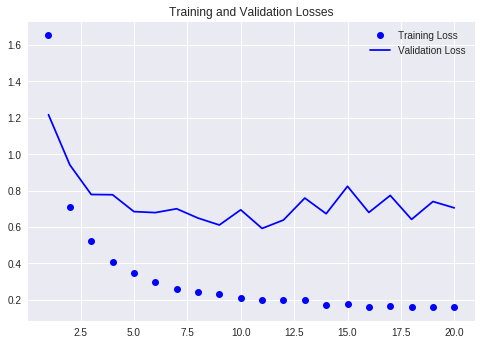

In [28]:
#visualization of model performance
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values =  history_dict['val_loss']
acc_values = history_dict['acc']

epochs = range(1, len(acc_values) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training Loss')
plt.plot(epochs,val_loss_values, 'b', label = 'Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel='Epochs'
plt.ylabel='Loss'
plt.legend()
plt.show()

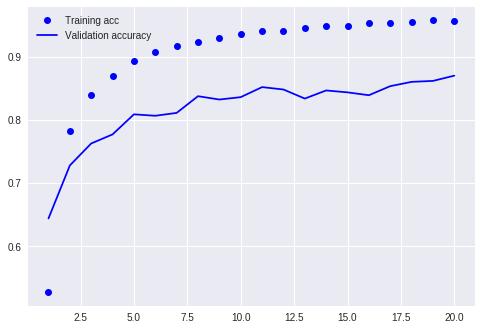

In [29]:
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs,val_acc_values, 'b', label='Validation accuracy')
plt.xlabel = 'Epochs'
plt.ylabel = 'Loss'
plt.legend()

plt.show()

## Validate against each of the test generators

In [0]:
save_generator_classes(train_generator)

In [31]:
for generator, _dir in zip(test_generators, LOCAL_TEST_DIRS):
  test_loss, test_acc = model.evaluate_generator(generator, steps=steps_per_epoch_test)
  print('{}: {}'.format(_dir, test_acc))

/tmp/data/asl_alphabet/processed_rgb_ahe_test: 0.9760869508204253
/tmp/data/asl_alphabet/split_asl_alphabet_test: 0.9630434746327607
/tmp/data/asl_alphabet/processed_ahe_grayscale_asl_test: 0.9782608643822048
